In [82]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torchvision.utils as vutils
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [83]:
projectName = "PokeGAN"

In [84]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [85]:
fullTransform = tt.Compose([
    tt.Resize(64),
    tt.CenterCrop(64),
    tt.ToTensor(),
    tt.Normalize(*stats),
])

In [86]:
dataDir = "../BackEnd/pokemon/"
dataset = ImageFolder(dataDir, transform=fullTransform)

In [87]:
img,label = dataset[0]
torch.min(img), torch.max(img)

(tensor(-1.), tensor(1.))

In [88]:
dataset.classes = ['real']
print(dataset.classes)

['real']


In [89]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
        
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
        
def show_example(img, label):
    print(img.shape)
    plt.imshow(denorm(img.permute(1, 2, 0)))

tensor(-1.)
torch.Size([3, 64, 64])


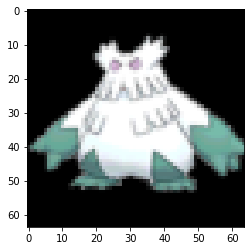

In [90]:
print(torch.min(dataset[0][0]))
show_example(*dataset[0])

torch.Size([3, 64, 64])


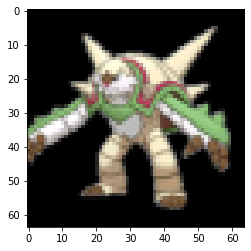

In [91]:
show_example(*dataset[100])

In [92]:
img, label = dataset[0]
img.shape

torch.Size([3, 64, 64])

In [93]:
randomSeed = 99
torch.manual_seed(randomSeed)

In [94]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [95]:
numWorkers = 3
batchSize = 64
imageSize = 64
numChannels = 3
latentS = 100
ngf = 64
ndf = 64
numEpochs = 10
lr = .0002
beta1 = .5

In [96]:
device = get_default_device()
device

device(type='cuda')

In [97]:
dataloader = DataLoader(dataset, batch_size = batchSize, shuffle = True, num_workers = numWorkers, pin_memory = True)

In [98]:
dataloader = DeviceDataLoader(dataloader, device)

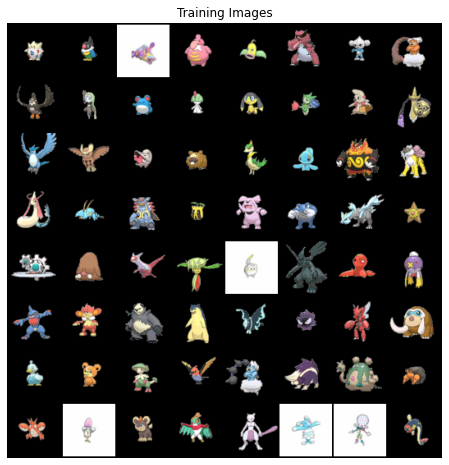

In [99]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [100]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [101]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latentS, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [102]:
gen = Generator().to(device)
gen.apply(weights_init)
print(gen)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [103]:
from torch.nn.utils import spectral_norm

In [104]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main1 = nn.Sequential(
            spectral_norm(nn.Conv2d(numChannels, ndf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(ndf * 8, 16, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

        self.main2 = nn.Linear(16, 1, bias=False)
        self.main3 = nn.Sigmoid()

    def forward(self, input, matching=True):
        features = self.main2(self.main1(input).view(-1,16))
        if matching:
          return features, self.main3(features)
        
        return self.main3(features)


In [105]:
dis = Discriminator().to(device)
dis.apply(weights_init)
print(dis)

Discriminator(
  (main1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 16, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
  (main2): Linear(in_features=

In [106]:
fixed_noise = torch.randn(batchSize, latentS, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(filter(lambda p: p.requires_grad, dis.parameters()), lr=lr, betas=(0.0,0.9))
optimizerG = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))

schedulerD = optim.lr_scheduler.ExponentialLR(optimizerD, gamma=0.99)
schedulerG = optim.lr_scheduler.ExponentialLR(optimizerG, gamma=0.99)

In [107]:
def noisy_labels(labels, prob):
    num = int(prob * labels.shape[0])
    flipped = np.random.choice([i for i in range(labels.shape[0])], size=num)
    
    for i in flipped:
        labels[i] = 1 - labels[i]
    
    return labels

In [108]:
def trainD(real_images, d_optim):
    #reset optimizer
    d_optim.zero_grad()
    
    # Pass real images through discriminator
    real_preds = dis(real_images, matching=False)
    real_targets = torch.randn(real_images.size(0), 1, device=device) * .15 + .85
    real_targets = noisy_labels(real_targets, .05)
    real_loss = criterion(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batchSize, latentS, 1, 1, device=device)
    fake_images = gen(latent)

    # Pass fake images through discriminator
    fake_targets = torch.randn(fake_images.size(0), 1, device=device) * .15 + .15
    fake_targets = noisy_labels(fake_targets, .05)
    fake_preds = dis(fake_images, matching=False)
    fake_loss = criterion(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    d_optim.step()
    return loss.item(), real_score, fake_score

In [109]:
def trainG(g_optim, real_images):
    # Clear generator gradients
    g_optim.zero_grad()
    
    # Generate fake images
    latent = torch.randn(real_images.size(0), latentS, 1, 1, device=device)
    fake_images = gen(latent)
    
    fakeFeatures, preds = dis(fake_images)
    image_pred, _ = dis(real_images)

    fakeFeaturesLoss = torch.mean(fakeFeatures, dim=0)
    imagePredLoss = torch.mean(image_pred, dim=0)

    loss = torch.mean((fakeFeaturesLoss - imagePredLoss) ** 2)
    
    loss.backward()
    g_optim.step()
    
    return loss.item()

In [110]:
from torchvision.utils import save_image

In [111]:
image_dir = 'generated'
os.makedirs(image_dir, exist_ok=True)

generator_dir = 'model/generator/'
discriminator_dir = "model/discriminator/"
os.makedirs(generator_dir, exist_ok=True)
os.makedirs(discriminator_dir, exist_ok=True)

In [112]:
def save_samples(index, fixed_noise, show=True):
    fake_images = gen(fixed_noise)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(image_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        plt.figure()
        fixed_imgs = gen(fixed_noise)
        result = denorm(fixed_imgs.cpu().data)
        result = make_grid(result)
        result = tt.Compose([tt.ToPILImage()])(result)
        plt.imshow(result)
        plt.axis('off')
        plt.show()
    
    if index%5==0:
        generatorFile = generator_dir+"generator-{0:0=4d}.pth".format(index)
        torch.save(gen, generatorFile)
        print("Saving: ", generatorFile)

        discriminatorFile = discriminator_dir+"discriminator-{0:0=4d}.pth".format(index)
        torch.save(dis, discriminatorFile)
        print("Saving: ", discriminatorFile)

Saving generated-images-0000.png


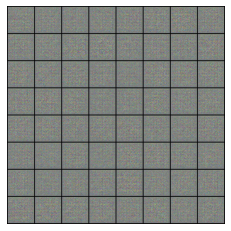

Saving:  model/generator/generator-0000.pth
Saving:  model/discriminator/discriminator-0000.pth


In [113]:
save_samples(0,fixed_noise)

In [114]:
from tqdm.notebook import tqdm

In [115]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloader):
            # Train discriminator
            loss_d, real_score, fake_score = trainD(real_images, optimizerD)
            # Train generator
            loss_g = trainG(optimizerG, real_images)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_noise, show=True)
        schedulerD.step()
        schedulerG.step()
    
    return losses_g, losses_d, real_scores, fake_scores


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 5.2211, loss_d: 1.0216, real_score: 0.8259, fake_score: 0.3393
Saving generated-images-0001.png


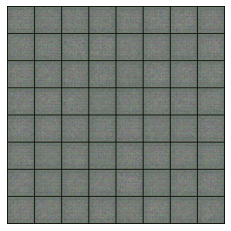

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 4.6838, loss_d: 1.0108, real_score: 0.8171, fake_score: 0.3355
Saving generated-images-0002.png


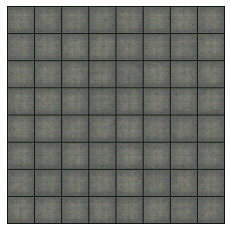

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 4.8998, loss_d: 1.0235, real_score: 0.8217, fake_score: 0.3307
Saving generated-images-0003.png


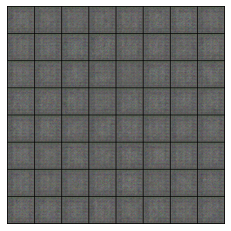

  0%|          | 0/13 [00:00<?, ?it/s]

In [116]:
lr = .0002
epochs = 50
history = fit(epochs, lr)

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

from IPython.display import Image

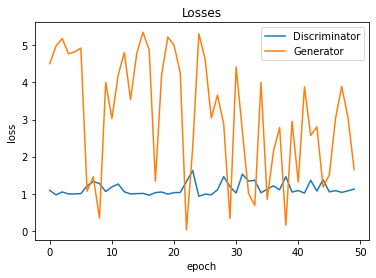

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

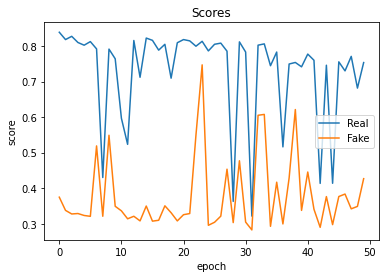

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

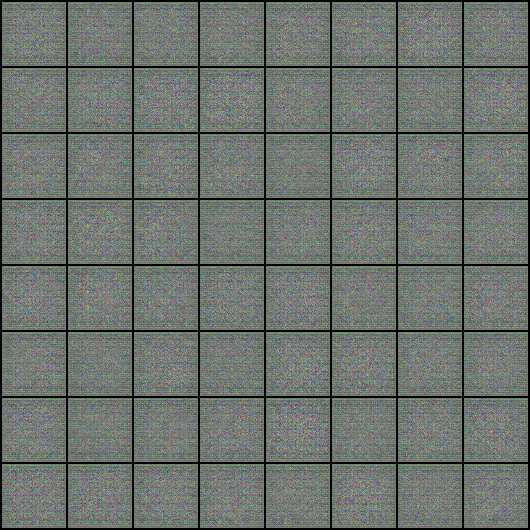

In [ ]:
Image('./generated/generated-images-0001.png')

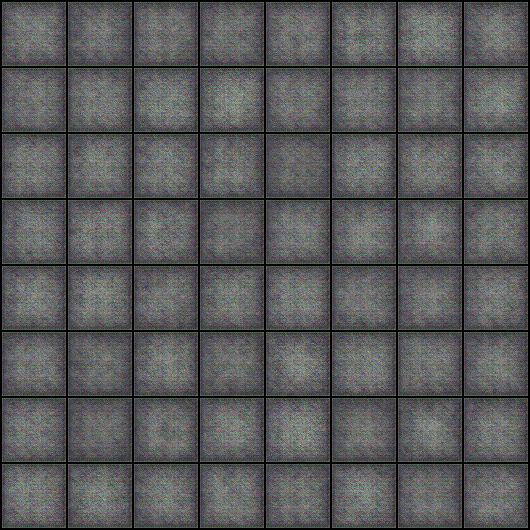

In [ ]:
Image('./generated/generated-images-0005.png')

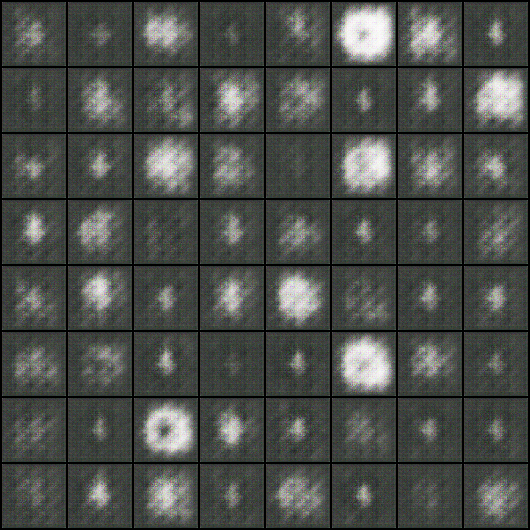

In [ ]:
Image('./generated/generated-images-0010.png')

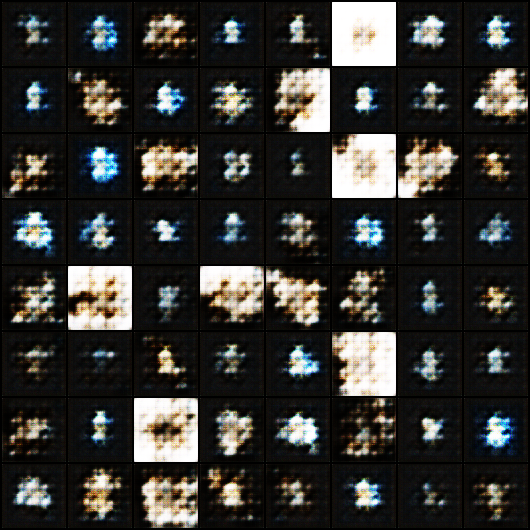

In [ ]:
Image('./generated/generated-images-0050.png')